# Hand motions classification using non-invasive EEG recordings
### by Cedric Simar and Antoine Passemiers
<hr/>

## Table of content

* [0 - Introduction](#introduction)
  * [0.1. Problem description](#problem-description)


* [1 - Preprocessing](#preprocessing)
  * [1.1. Import useful libraries](#import-libraries)
  * [1.2. Load the data](#load-data)
  * [1.3. Band-pass filtering](#band-pass-filtering)
  * [1.4. Downsampling](#downsampling)
  * [1.5. Extract covariance matrices](#extract-cov)


* [2. Riemannian-based kernel trick](#kernel-trick)


* [3. Models](#models)
  * [3.1. Linear Discriminant Analysis](#lda)


* [4. Bibliography](#bibliography)

## Introduction <a class="anchor" id="introduction"></a>
<hr/>

### Problem description <a class="anchor" id="problem-description"></a>

In [1]:
from IPython.display import HTML
url = "https://www.youtube.com/embed/y3_Izuop2gY?rel=0&amp;controls=0&amp;showinfo=0"
HTML('<iframe style="display:block" width="560" height="315" src="%s" frameborder="0" allowfullscreen></iframe>' % url)

## Preprocessing <a class="anchor" id="preprocessing"></a>
<hr/>

### Import useful libraries <a class="anchor" id="import-libraries"></a>

In [52]:
%load_ext Cython

import cython
import os
import gc
import time
import scipy.linalg
import scipy.signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### Load the data <a class="anchor" id="load-data"></a>

TODO Cedric: descriptions (electrodes, multi-labels, échantillonage, tout ça tout ça)

<figure style="text-align:center;">
  <img src="imgs/EEG_Electrode_Numbering.jpg" style="width:450px;">
  <figcaption> Source: [Kaggle](#bib-kaggle) </figcaption>
</figure>

In [45]:
N_PATIENTS = 12
# Feature names
ELECTRODE_NAMES = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10',
    'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
# Label names
EVENT_NAMES = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']


def load_dataset(subject=1, data_dir='', series=range(1,9)):
    data, events = list(), list()
    for series_id, s in enumerate(series):
        print("Load series {0} from patient {1}".format(series_id+1, subject))
        data_filepath = os.path.join(data_dir, "train/subj{0}_series{1}_data.csv".format(subject, s))
        data.append(pd.read_csv(data_filepath, index_col=0).values.astype(np.float))
        events_filepath = os.path.join(data_dir, "train/subj{0}_series{1}_events.csv".format(subject, s))
        events.append(pd.read_csv(events_filepath, index_col=0).values)
    return data, np.concatenate(events, axis=0)

In [46]:
data, events = load_dataset(subject=1, data_dir='data')

Load series 1 from patient 1
Load series 2 from patient 1
Load series 3 from patient 1
Load series 4 from patient 1
Load series 5 from patient 1
Load series 6 from patient 1
Load series 7 from patient 1
Load series 8 from patient 1


In [25]:
class LowPassFilter:
    
    def __init__(self, cutoff_freq, sampling_freq, order=3):
        self.nyquist_freq = sampling_freq / 2.
        bound = cutoff_freq / self.nyquist_freq
        self.b, self.a = scipy.signal.butter(order, bound, btype='lowpass', analog=True)
    
    def filter(self, signal):
        # TODO: does lfiter include future data when filtering current frame?
        return scipy.signal.lfilter(self.b, self.a, signal, axis=0)

In [47]:
Fp1 = [series[:, 0] for series in data] # TODO: electrode 0 or 15
filtered = list()
for cutoff_freq in np.linspace(0, 1, 11)[1:]:
    lowpass = LowPassFilter(cutoff_freq, 500)
    filtered.append(np.concatenate([lowpass.filter(series_fp1) for series_fp1 in Fp1], axis=0)[:, np.newaxis])
filtered = np.concatenate(filtered, axis=1)
X_train_raw = np.concatenate((np.concatenate(data, axis=0), filtered, filtered ** 2), axis=1)

In [48]:
X_train_downsampled = X_train_raw[::4000]
y_downsampled = events[::4000]

In [49]:
scaler = StandardScaler(copy=False)
X_train_downsampled = scaler.fit_transform(X_train_downsampled)

print(X_train_downsampled.shape)

(356, 52)


In [50]:
X_train, X_val = X_train_downsampled[:200], X_train_downsampled[200:]
y_train, y_val = y_downsampled[:200], y_downsampled[200:]

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 ..., 
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [55]:
for i in range(6):
    rf = RandomForestClassifier(n_estimators=150, criterion="entropy")
    rf.fit(X_train, y_train[:, i])
    scores = rf.predict_proba(X_val)[:, 1]
    print(roc_auc_score(y_val[:, i], scores))

0.572368421053
0.716175359033
0.759712837838
0.478906999041
0.547077922078
0.782467532468


### Band-pass filtering <a class="anchor" id="band-pass-filtering"></a>

To avoid creating potential aliasing effects, we apply necessary spectral filters on the raw signals before to downsample them.

In [11]:
class BandPassFilter:
    
    def __init__(self, lowcut_freq, highcut_freq, sampling_freq, order=3):
        self.nyquist_freq = sampling_freq / 2.
        lower_bound = lowcut_freq / self.nyquist_freq
        upper_bound = highcut_freq / self.nyquist_freq
        self.b, self.a = scipy.signal.butter(order, [lower_bound, upper_bound], btype='band', analog=True)
    
    def lfilter(self, signal):
        # TODO: does lfiter include future data when filtering current frame?
        return scipy.signal.lfilter(self.b, self.a, signal, axis=0)

In [12]:
# Sampling frequency: 500 Hz (from the dataset description)
# Filter band of interest: 0.1 Hz to 45 Hz (µ and β frequency bands)
bandpass = BandPassFilter(.1, 45, 500)

X_train_filtered = bandpass.lfilter(X_train)

### Downsampling <a class="anchor" id="downsampling"></a>

In [13]:
# 500 Hz -> 125 Hz
X_train_filtered_125Hz, Y_train_125Hz = X_train_filtered[::4], Y_train[::4]

### Extract covariance matrices <a class="anchor" id="extract-cov"></a>

In [7]:
%%cython

import numpy as np
cimport numpy as cnp
cnp.import_array()
import cython

@cython.boundscheck(False)
@cython.overflowcheck(False)
def extract_cov_matrices(cnp.float_t[:, :] data, Py_ssize_t w):
    cdef Py_ssize_t n_features = data.shape[1]
    cdef cnp.float_t[:, :, :] sigmas = np.empty((data.shape[0], n_features, n_features), dtype=np.float)
    cdef cnp.float_t[:] means = np.asarray(np.mean(np.asarray(data)[:w, :], axis=0), dtype=np.float)
    cdef cnp.float_t[:] old_means = np.copy(means)
    cdef cnp.float_t[:, :] last_sigma = np.cov(np.asarray(data)[:w, :].T)
    cdef cnp.float_t c
    np_sigmas = np.asarray(sigmas)
    np_sigmas[:w, :, :] = np.repeat(np.asarray(last_sigma).reshape((1, n_features, n_features), order='C'), w, axis=0)
    cdef Py_ssize_t i, j, a, b
    with nogil:
        for i in range(w, data.shape[0]):
            for a in range(n_features):
                old_means[a] = means[a]
                means[a] += (data[i, a] - data[i-w, a]) / w
            for a in range(n_features):
                for b in range(a+1):
                    c = sigmas[i-1, a, b]
                    c += (data[i, a] * data[i, b] - data[i-w, a] * data[i-w, b]) / w
                    c += old_means[a] * old_means[b] - means[a] * means[b]
                    sigmas[i, a, b] = sigmas[i, b, a] = c
    return np_sigmas

In [36]:
X_train_cov = extract_cov_matrices(X_train_filtered_125Hz[:100000].astype(np.float), 900)
Y_train_125Hz_sub = Y_train_125Hz[:100000]

X_train_cov = X_train_cov[::20]
Y_train_125Hz_sub = Y_train_125Hz_sub[::20]

## Riemannian-based kernel trick <a class="anchor" id="kernel-trick"></a>

In [38]:
def hlmap(Cp, sqrtCinv):
    return scipy.linalg.logm(sqrtCinv * Cp * sqrtCinv)

def hemap(Cp, sqrtC):
    return scipy.linalg.expm(sqrtC * Cp * sqrtC)

def project_cov_matrices(X):
    """ X is of shape (n_samples, n_electrodes, n_electrodes) """
    sqrtC = scipy.linalg.sqrtm(X.mean(axis=0))
    sqrtCinv = scipy.linalg.inv(sqrtC)
    return np.asarray([hlmap(h, sqrtCinv) for h in X])

This step might take a couple a minutes...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


(5000, 32, 32)


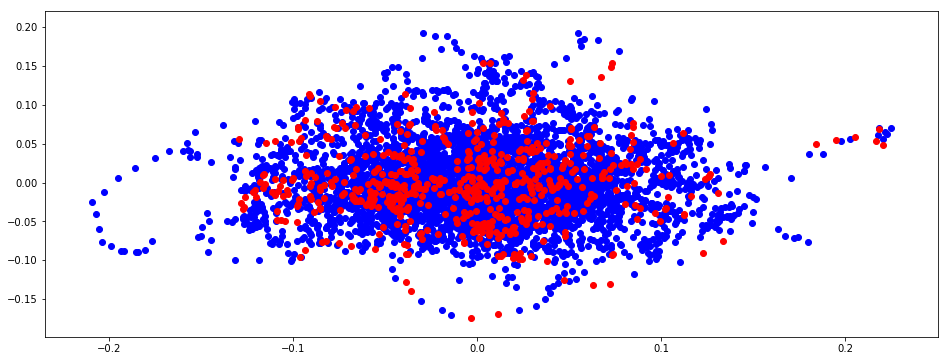

In [50]:
pca = PCA(n_components=X_train_cov.reshape(len(X_train_cov), -1).shape[1])
points = pca.fit_transform(X_train_cov.reshape(len(X_train_cov), -1))
print(X_train_cov.shape)
points = points[:, 29:31]

labels = Y_train_125Hz_sub
nothing = labels.sum(axis=1) == 0
something = labels.sum(axis=1) > 0

plt.figure(figsize=(16, 6))
plt.scatter(points[nothing, 0], points[nothing, 1], c='blue')
plt.scatter(points[something, 0], points[something, 1], c='red')
plt.show()

## Models <a class="anchor" id="models"></a>
<hr/>

### Linear discriminant analysis <a class="anchor" id="lda"></a>

In [49]:
from sklearn.lda import LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef

_X_train = X_train_cov[:4000]
_X_train = _X_train.reshape(_X_train.shape[0], -1)
_Y_train = Y_train_125Hz_sub[:4000]

_X_val = X_train_cov[4000:]
_X_val = _X_val.reshape(_X_val.shape[0], -1)
_Y_val = Y_train_125Hz_sub[4000:]

for i in range(6):
    clf = RandomForestClassifier()
    clf.fit(_X_train, _Y_train[:, i])
    print(matthews_corrcoef(_Y_train[:, i], clf.predict(_X_train)))
    print(matthews_corrcoef(_Y_val[:, i], clf.predict(_X_val)))
    print(clf.predict(_X_val).sum(), "\n")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.434188107113
0.0
0 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.248987659598
0.0
0 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.591487769434
0.0
0 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.652333426419
0.0
0 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.380430093938
0.0
0 

0.653065610102
0.0
0 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:382: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


## Bibliography <a class="anchor" id="bibliography"></a>
<hr/>

* <span class="anchor" id="bib-riemann">
    [1] Classification of covariance matrices using a Riemannian-based kernel for BCI applications <br>
    Alexandre Barachant, Stéphane Bonnet, Marco Congedo, Christian Jutten <br>
    https://hal.archives-ouvertes.fr/file/index/docid/820475/filename/BARACHANT_Neurocomputing_ForHal.pdf <br>
  </span>
<br>

* <span class="anchor" id="bib-kaggle">
    [2] Grasp-and-Lift EEG Detection Kaggle Competition <br>
    https://www.kaggle.com/c/grasp-and-lift-eeg-detection <br>
  </span>
<br>